# Machine Learning - Regression

In [192]:
# Importing packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline
from statsmodels.api import OLS, add_constant
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 1. Business goal
Build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set, in order to predict the demand for bicycle rentals at any given hour, based on time and weather.

## 2. Get data

In [193]:
df = pd.read_csv('../data/train.csv')
df.shape
df[df["weather"]==4].head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164


In [194]:
# Handle time data
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['day_of_year'] = df['datetime'].dt.dayofyear
df['day_of_week'] = df['datetime'].dt.weekday

## 3. Train / Test split

In [195]:
# Replace year
condition = [
    (df['year']==2011),
    (df['year']==2012)
]

values = [0, 1]

df['year'] = np.select(condition, values)

In [196]:
y = df["count"]
X = df.drop(["casual", "registered", "count", "datetime", "day_of_year"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8708, 13) (2178, 13) (8708,) (2178,)


## 4. Explore the data

In [197]:
# Re-combine X and y of training set in one dataframe for data exploration
df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)
print(df_train.shape)
print(df_test.shape)
print(df_train.head())

(8708, 14)
(2178, 14)
      season  holiday  workingday  weather   temp   atemp  humidity  \
2815       3        0           1        1  27.88  31.820        83   
8695       3        0           0        1  36.90  40.910        39   
8406       3        0           1        1  32.80  35.605        41   
1543       2        0           0        2  14.76  18.180        93   
4952       4        0           0        1  13.12  15.150        45   

      windspeed  year  month  day  hour  day_of_week  count  
2815     6.0032     0      7    6     5            2     35  
8695    19.9995     1      8    4    16            5    450  
8406    16.9979     1      7   11    15            2    276  
1543     7.0015     0      4   10     4            6      5  
4952    16.9979     0     11   19    10            5    200  


### Datetime _versus_ count

#### A) Complete time range
10.886 observations covering a time range of 2 years were provided in the training dataset.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'The dataset comprises 10886 bicicle rent status data recorded between 2011-01-01 00:00:00 and 2012-12-19 23:00:00')

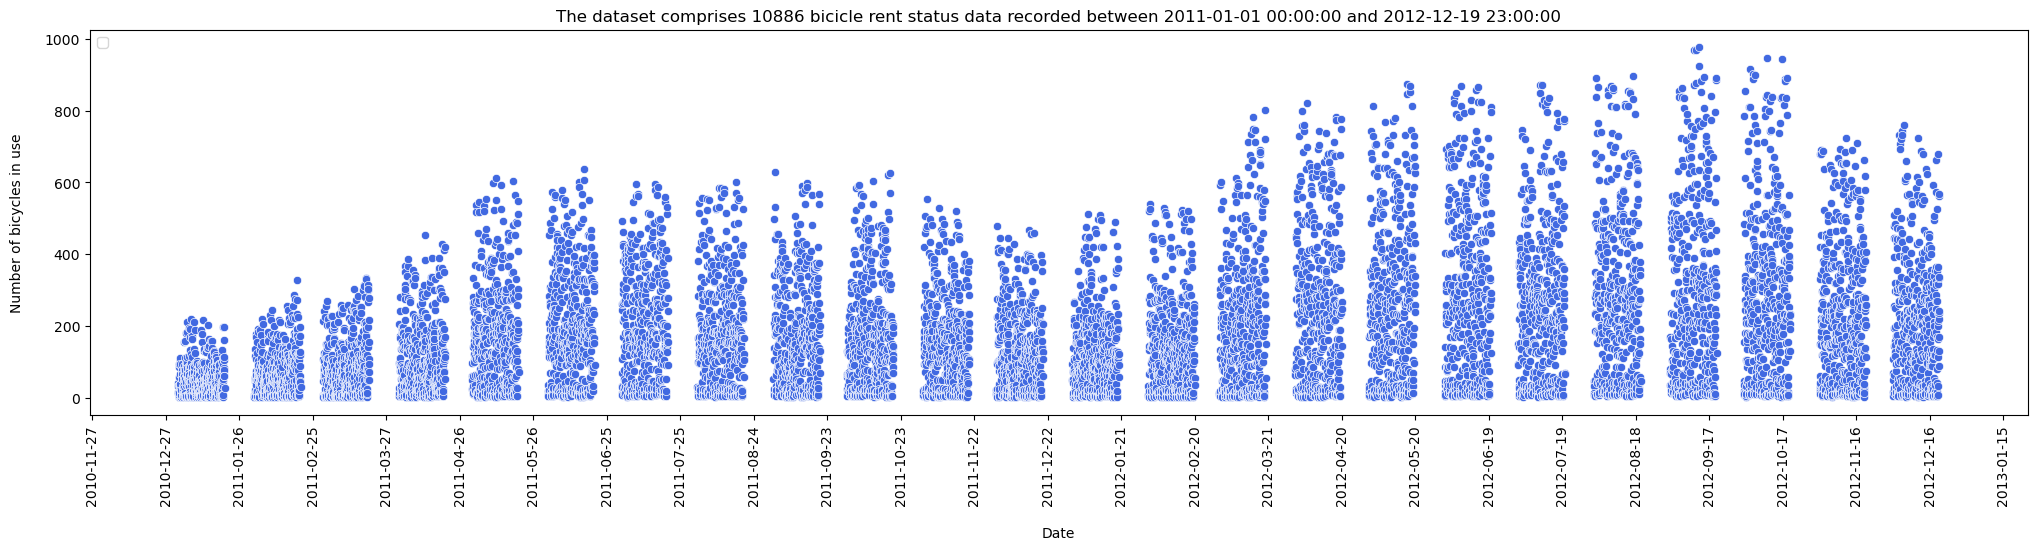

In [198]:
plt.close()
plt.figure(figsize=(25,5))
# Create the plot
scatter = sns.scatterplot(x=df['datetime'], y=df['count'], color="royalblue")
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all dates are plotted
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
plt.legend(loc="upper left")
scatter.xaxis.labelpad = 15
scatter.yaxis.labelpad = 15
plt.xlabel("Date")
plt.ylabel("Number of bicycles in use")
plt.title("The dataset comprises "+str(df['count'].count())+" bicicle rent status data recorded between "+str(df['datetime'].min())+" and "+str(df['datetime'].max()))

#### B) 3 months
For every month only data for the time range 1st of the month to 20th of the month are present. Data form the 20th onward are missing for every month.

Text(0, 0.5, 'Number of bicycles in use')

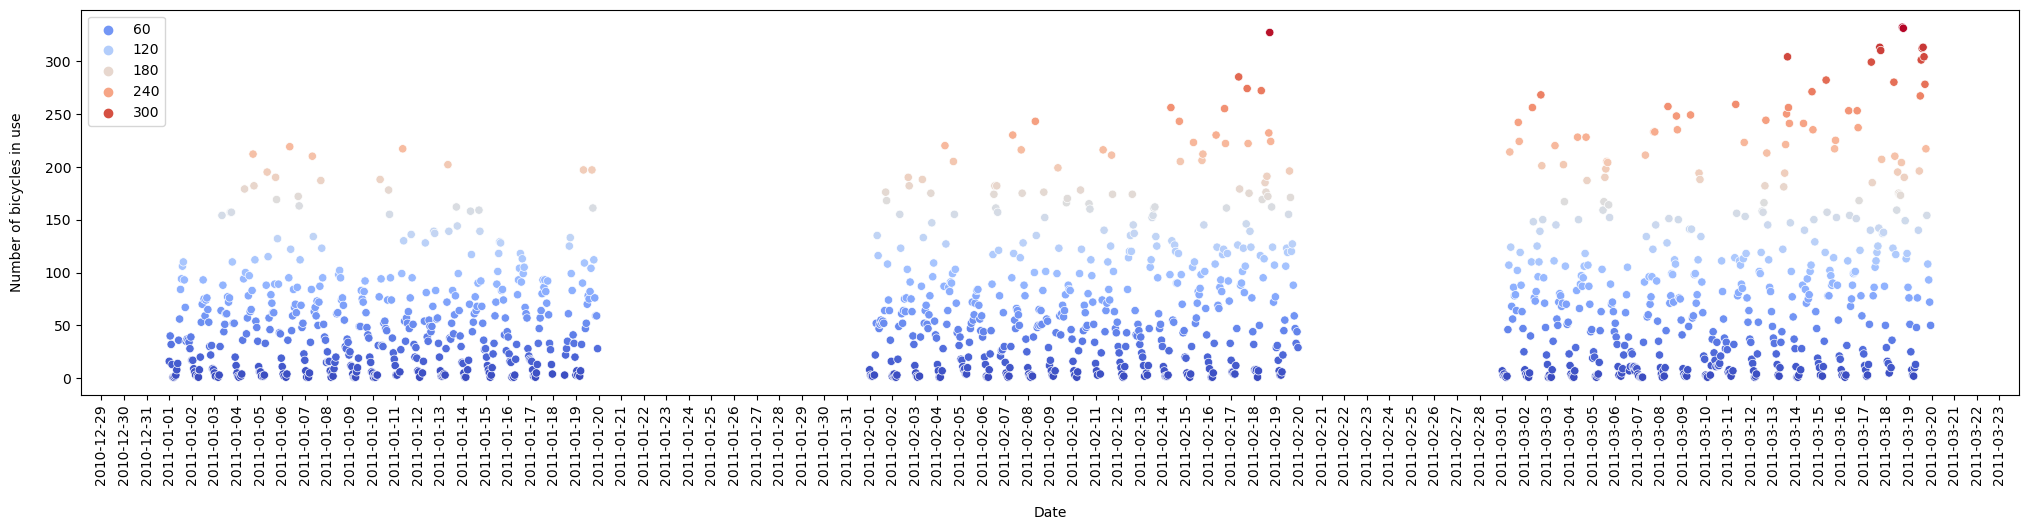

In [199]:
# Look at data for 3 months
df_3months = df[df['datetime']<pd.to_datetime('2011-04-01')]
plt.close()
# Make plot very wide
plt.figure(figsize=(25,5))
# Create the plot
scatter = sns.scatterplot(x=df_3months['datetime'], y=df_3months['count'], hue=df_3months['count'], palette=sns.color_palette('coolwarm', as_cmap = True))
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all dates are plotted
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc="upper left")
scatter.xaxis.labelpad = 15
scatter.yaxis.labelpad = 15
plt.xlabel("Date")
plt.ylabel("Number of bicycles in use")

#### C) 1 month
Although more bikes are rented in a summer month than in a winter month, the overall patter of the distribution of the rentals seems to be the same. It likely is based on the weeks / holidays and time of the day.

Text(0, 0.5, 'Number of bicycles in use')

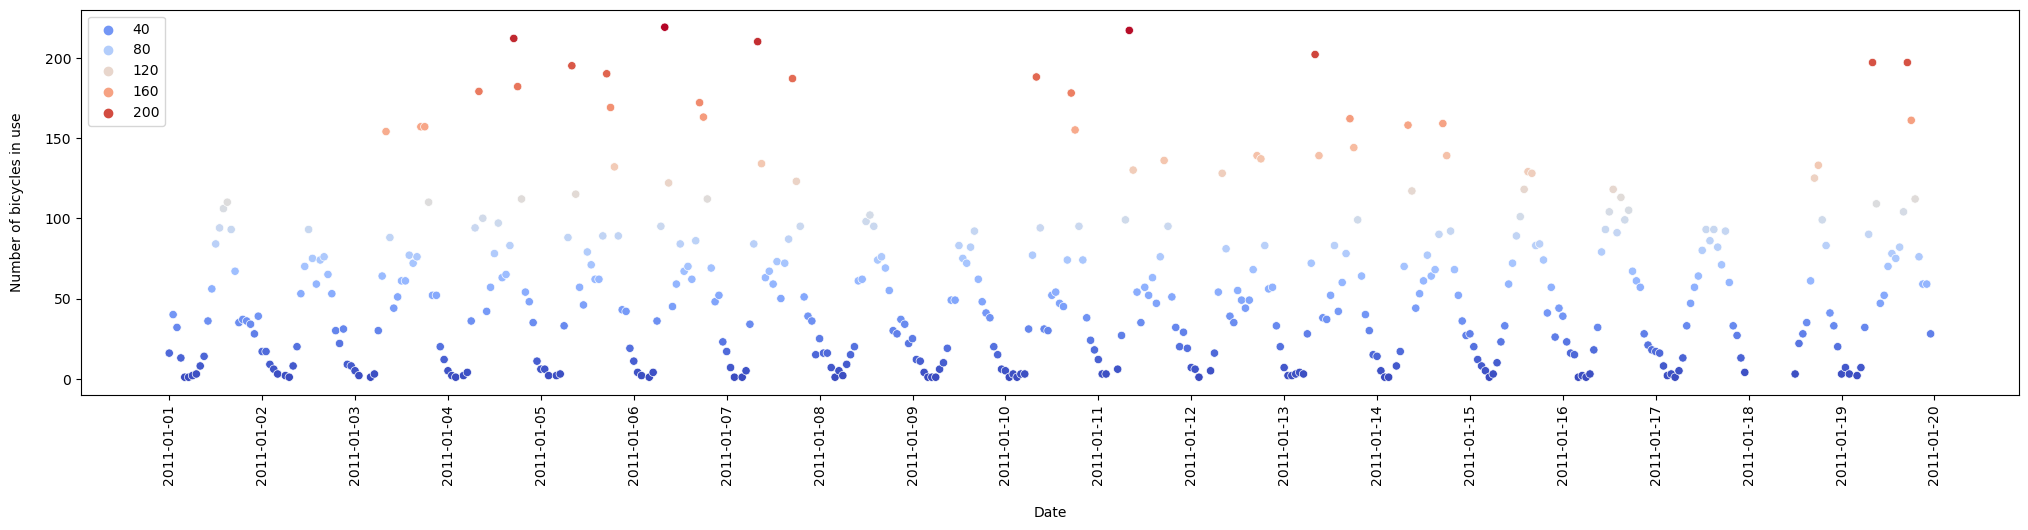

In [200]:
# Look at data for 1 month - at the beginning
df_1month_1 = df[df['datetime']<pd.to_datetime('2011-01-21')]
plt.close()
# Make plot very wide
plt.figure(figsize=(25,5))
# Create the plot
scatter = sns.scatterplot(x=df_1month_1['datetime'], y=df_1month_1['count'], hue=df_1month_1['count'], palette=sns.color_palette('coolwarm', as_cmap = True))
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all dates are plotted
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc="upper left")
scatter.xaxis.labelpad = 15
scatter.yaxis.labelpad = 15
plt.xlabel("Date")
plt.ylabel("Number of bicycles in use")

Text(0, 0.5, 'Number of bicycles in use')

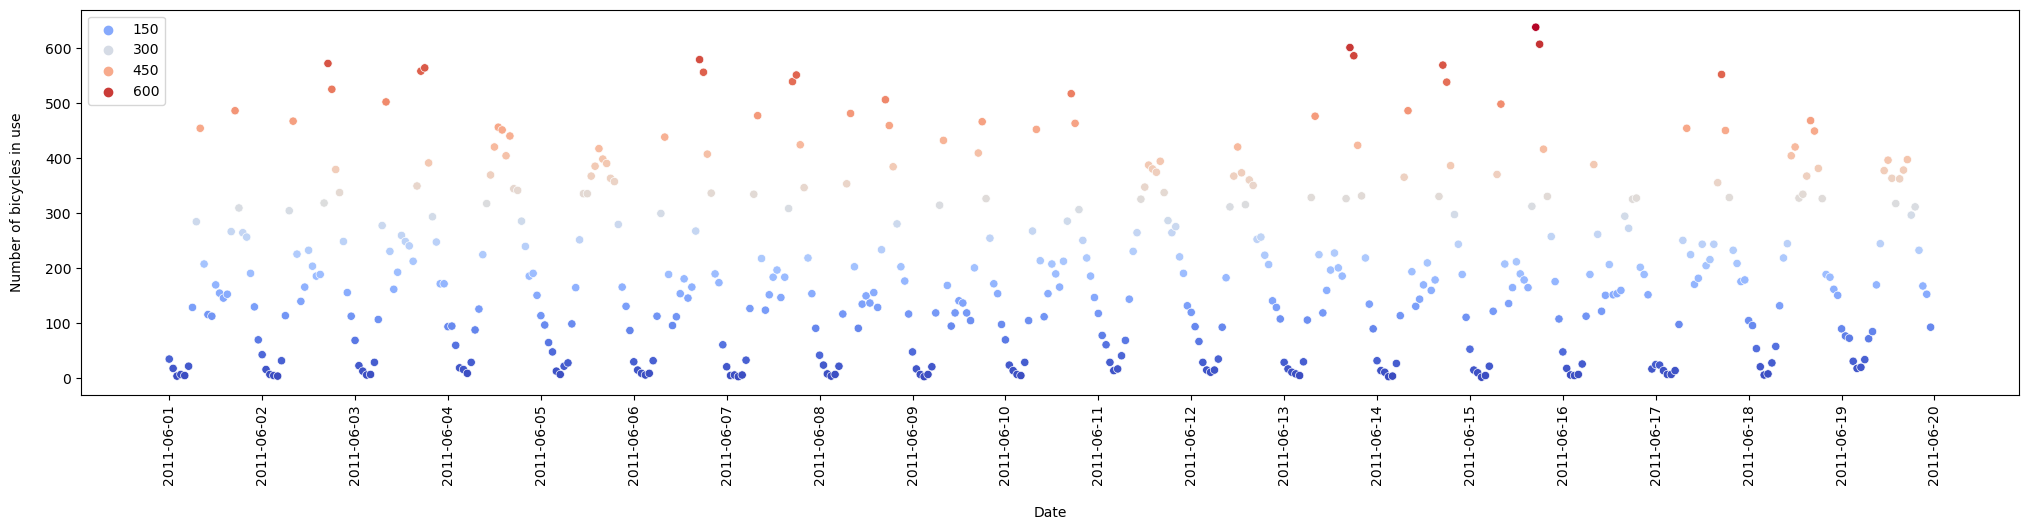

In [201]:
# Look at data for 1 month - in the summer of the first year
df_1month_2 = df[(pd.to_datetime('2011-05-31')<df['datetime'])&(df['datetime']<pd.to_datetime('2011-06-21'))]
plt.close()
# Make plot very wide
plt.figure(figsize=(25,5))
# Create the plot
scatter = sns.scatterplot(x=df_1month_2['datetime'], y=df_1month_2['count'], hue=df_1month_2['count'], palette=sns.color_palette('coolwarm', as_cmap = True))
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all dates are plotted
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc="upper left")
scatter.xaxis.labelpad = 15
scatter.yaxis.labelpad = 15
plt.xlabel("Date")
plt.ylabel("Number of bicycles in use")

Text(0, 0.5, 'Number of bicycles in use')

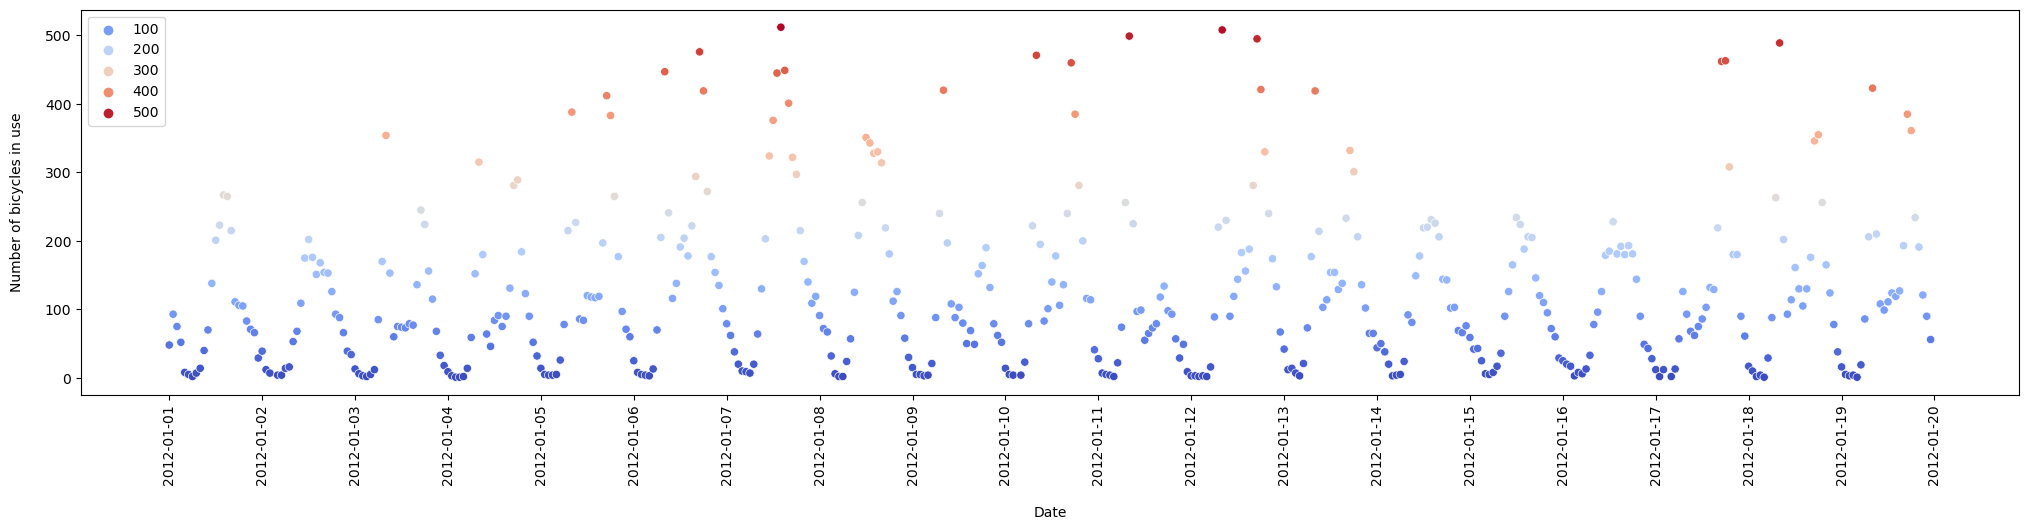

In [202]:
# Look at data for 1 month - in the winter of the second year
df_1month_3 = df[(pd.to_datetime('2011-12-31')<df['datetime'])&(df['datetime']<pd.to_datetime('2012-01-21'))]
plt.close()
# Make plot very wide
plt.figure(figsize=(25,5))
# Create the plot
scatter = sns.scatterplot(x=df_1month_3['datetime'], y=df_1month_3['count'], hue=df_1month_3['count'], palette=sns.color_palette('coolwarm', as_cmap = True))
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all dates are plotted
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc="upper left")
scatter.xaxis.labelpad = 15
scatter.yaxis.labelpad = 15
plt.xlabel("Date")
plt.ylabel("Number of bicycles in use")

Text(0, 0.5, 'Number of bicycles in use')

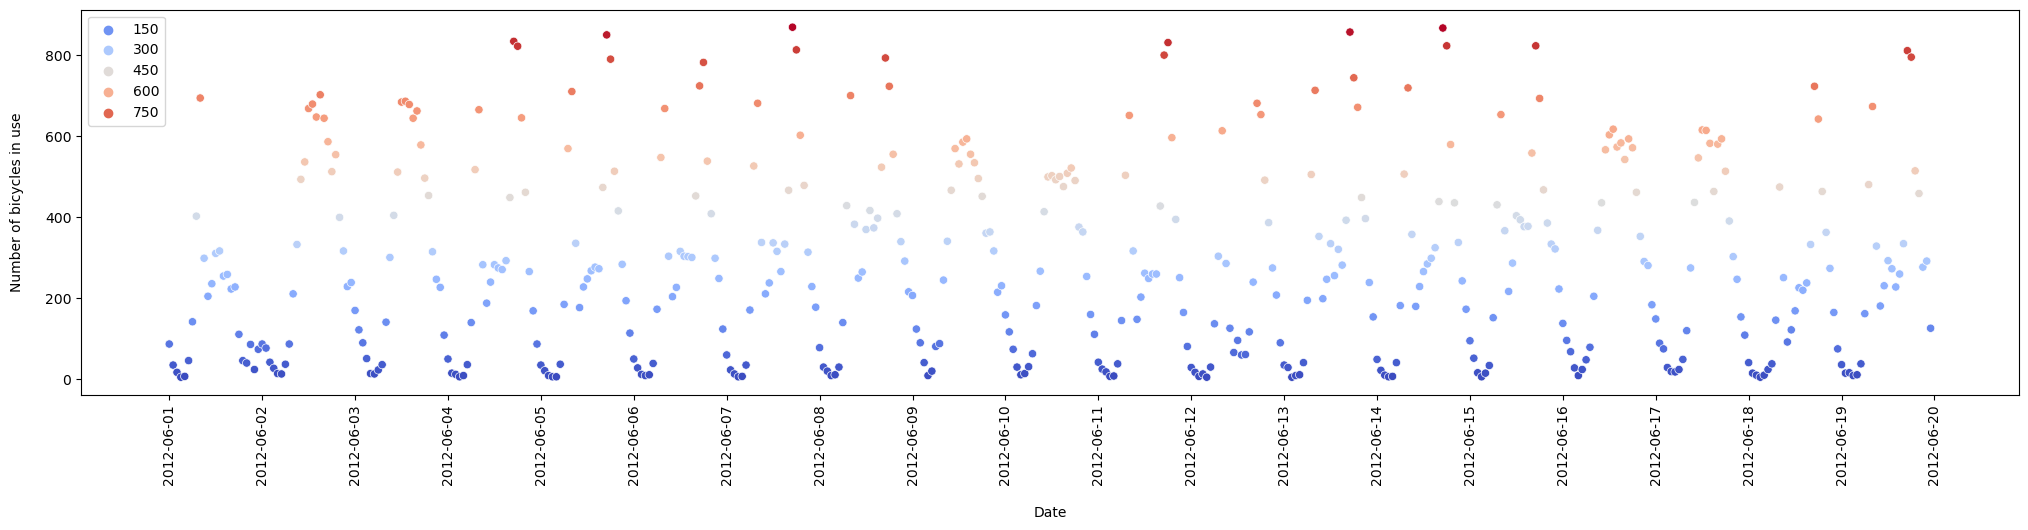

In [203]:
# Look at data for 1 month - in the summer of the second year
df_1month_4 = df[(pd.to_datetime('2012-05-31')<df['datetime'])&(df['datetime']<pd.to_datetime('2012-06-21'))]
plt.close()
# Make plot very wide
plt.figure(figsize=(25,5))
# Create the plot
scatter = sns.scatterplot(x=df_1month_4['datetime'], y=df_1month_4['count'], hue=df_1month_4['count'], palette=sns.color_palette('coolwarm', as_cmap = True))
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all dates are plotted
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc="upper left")
scatter.xaxis.labelpad = 15
scatter.yaxis.labelpad = 15
plt.xlabel("Date")
plt.ylabel("Number of bicycles in use")

#### D) One year with maximum number of bicycles in use per day
There exists a clear dependency between the maximum number of bicycles rented per day and the type of the day, i.e. holiday, non-working day, working day. Overall the Number of bicyles rented per day is lower for holidays and non-working days than for working days.
On days with bad weather conditions (weather status 3 or 4) the maximum number of bicycles in use per days is usually lower than on days with good weather conditions.

Text(0.5, 1.0, 'Maximum number of bicycles in use on a day in 2011')

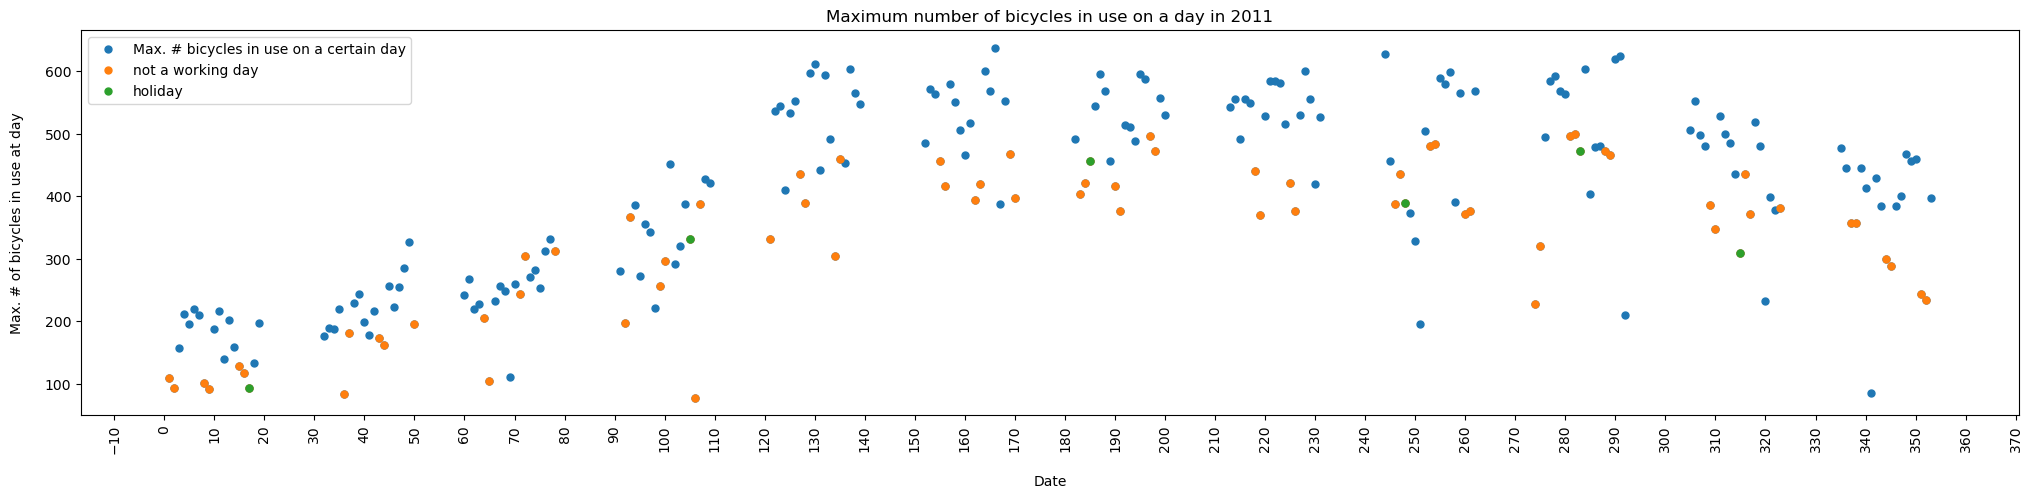

In [204]:
# Look at data for 1 month - in the summer of the second year
df_year_1 = df[(pd.to_datetime('2010-12-31')<df['datetime'])&(df['datetime']<pd.to_datetime('2012-01-01'))]
plt.close()
# Make plot very wide
plt.figure(figsize=(25,5))
# Create the plot
yplot = df_year_1.groupby('day_of_year')['count'].max().plot(style='.', ms=10, label="Max. # bicycles in use on a certain day")
df_year_1.loc[df_year_1['workingday']==0, ['day_of_year', 'count']].groupby('day_of_year')['count'].max().plot(style='.', ms=10, label="not a working day")
df_year_1.loc[df_year_1['holiday']==1, ['day_of_year', 'count']].groupby('day_of_year')['count'].max().plot(style='.', ms=10, label="holiday")
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all days of the year are plottet on x-axis
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
yplot.xaxis.labelpad = 15
yplot.yaxis.labelpad = 15
plt.xlabel("Date")
plt.ylabel("Max. # of bicycles in use at day")
plt.legend(loc="upper left")
plt.title("Maximum number of bicycles in use on a day in 2011")

Text(0.5, 1.0, 'Maximum number of bicycles in use on a day in 2012')

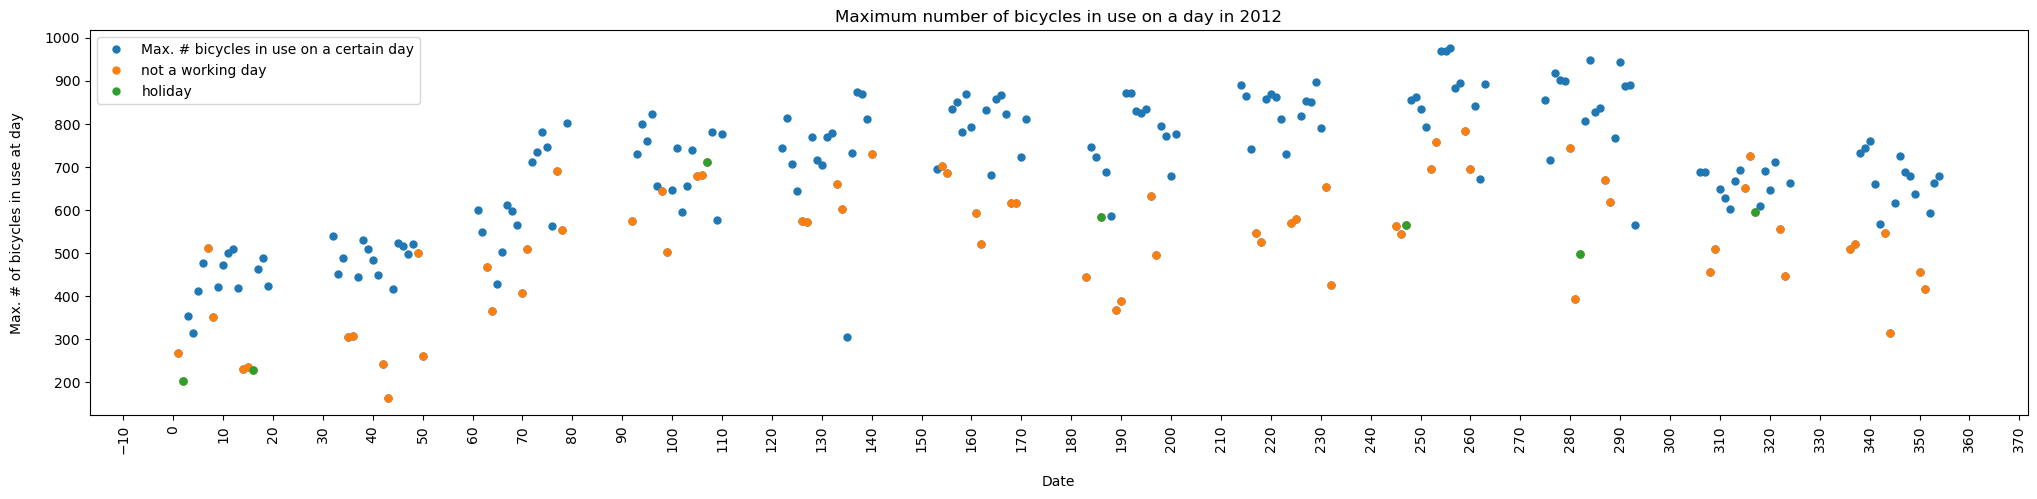

In [205]:
# Look at data for 1 month - in the summer of the second year
df_year_2 = df[(pd.to_datetime('2011-12-31')<df['datetime'])&(df['datetime']<pd.to_datetime('2013-01-01'))]
plt.close()
# Make plot very wide
plt.figure(figsize=(25,5))
# Create the plot
yplot = df_year_2.groupby('day_of_year')['count'].max().plot(style='.', ms=10, label="Max. # bicycles in use on a certain day")
df_year_2.loc[df_year_2['workingday']==0, ['day_of_year', 'count']].groupby('day_of_year')['count'].max().plot(style='.', ms=10, label="not a working day")
df_year_2.loc[df_year_2['holiday']==1, ['day_of_year', 'count']].groupby('day_of_year')['count'].max().plot(style='.', ms=10, label="holiday")
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all days of the year are plottet on x-axis
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
yplot.xaxis.labelpad = 15
yplot.yaxis.labelpad = 15
plt.xlabel("Date")
plt.ylabel("Max. # of bicycles in use at day")
plt.legend(loc="upper left")
plt.title("Maximum number of bicycles in use on a day in 2012")

Text(0.5, 1.0, 'Maximum number of bicycles in use on a day in 2011')

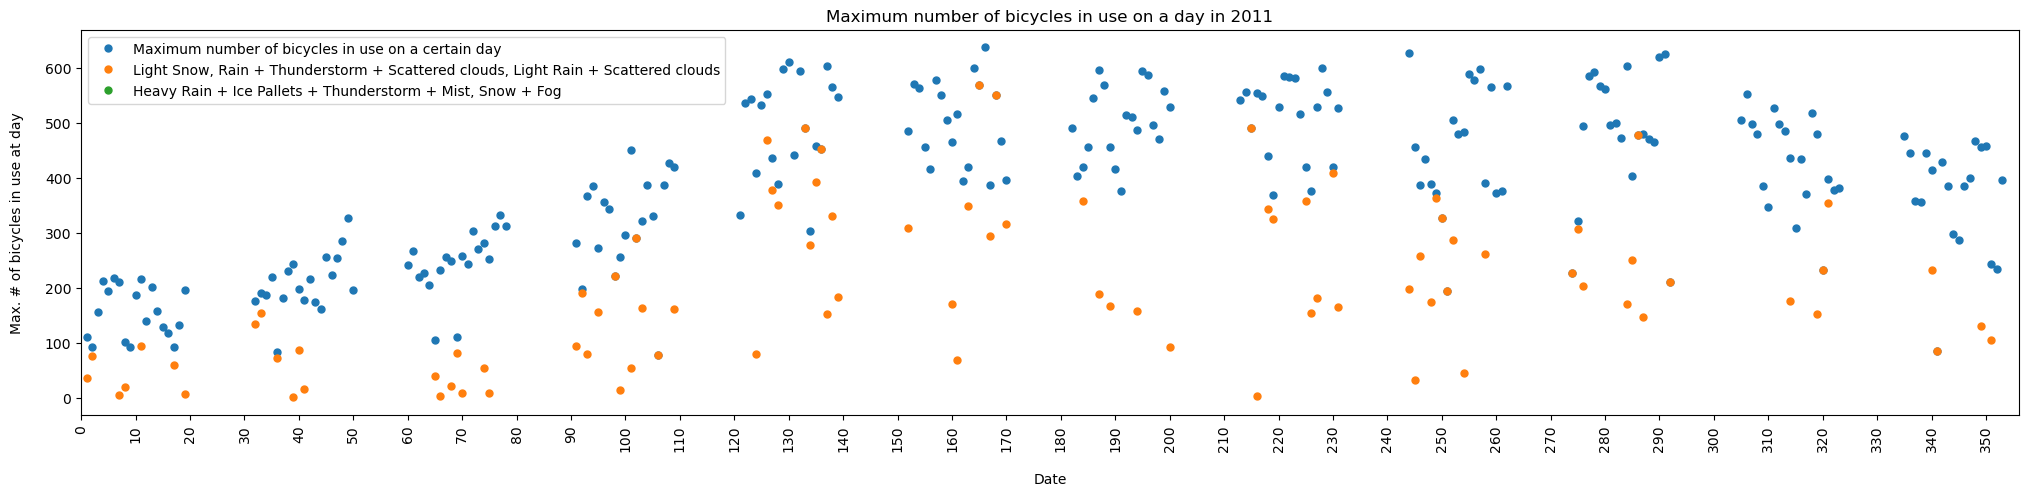

In [206]:
# Look at data for 1 month - in the summer of the second year
df_year_1 = df[(pd.to_datetime('2010-12-31')<df['datetime'])&(df['datetime']<pd.to_datetime('2012-01-01'))]
plt.close()
# Make plot very wide
plt.figure(figsize=(25,5))
# Create the plot
yplot = df_year_1.groupby('day_of_year')['count'].max().plot(style='.', ms=10, label="Maximum number of bicycles in use on a certain day")
df_year_1.loc[df_year_1['weather']==3, ['day_of_year', 'count']].groupby('day_of_year')['count'].max().plot(style='.', ms=10, label="Light Snow, Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds")
df_year_1.loc[df_year_1['weather']==4, ['day_of_year', 'count']].groupby('day_of_year')['count'].max().plot(style='.', ms=10, label="Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog")
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all days of the year are plottet on x-axis
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
yplot.xaxis.labelpad = 15
yplot.yaxis.labelpad = 15
plt.xlabel("Date")
plt.xlim([0, 356])
plt.ylabel("Max. # of bicycles in use at day")
plt.legend(loc="upper left")
plt.title("Maximum number of bicycles in use on a day in 2011")

#### E) All data with mean per month
There exists a sinus like dependency between the month of the year and the average number of bicicles rented per month, with the maximum at approximately July and a minimum in January.

Text(0.5, 1.0, 'Mean number of bicycles in use per month')

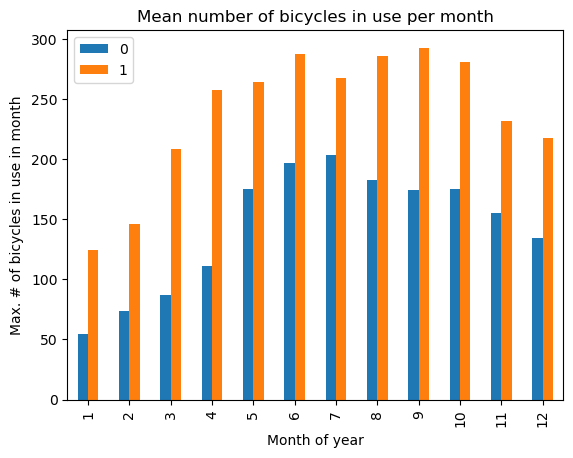

In [207]:
plt.close()
# Create the plot
yplot = df.groupby(['month', 'year'])['count'].mean().unstack().plot(kind="bar")
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=90)
# Ensure that all days of the year are plottet on x-axis
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
yplot.xaxis.labelpad = 5
yplot.yaxis.labelpad = 5
plt.xlabel("Month of year")
plt.ylabel("Max. # of bicycles in use in month")
plt.legend(loc="upper left")
plt.title('Mean number of bicycles in use per month')

#### F) Rentals per hour of the day

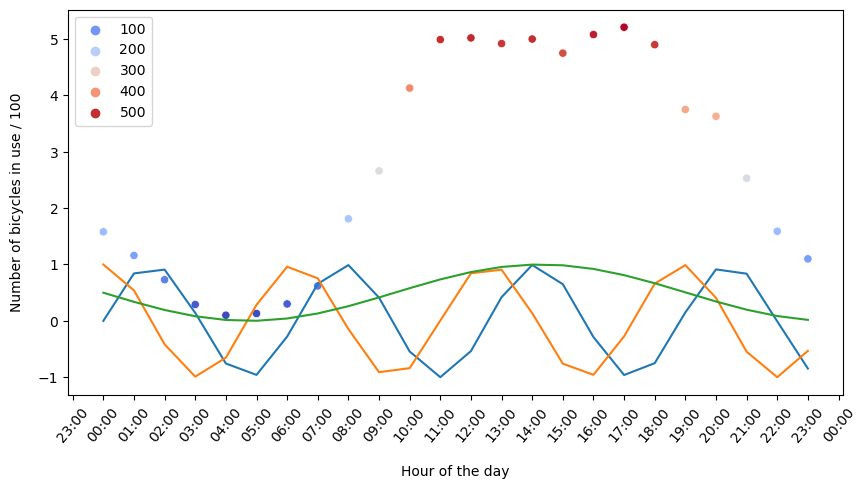

In [208]:
# Look at data for 1 month - in the summer of the second year
df_day_1 = df[(pd.to_datetime('2012-06-09 23:55:00')<df['datetime'])&(df['datetime']<pd.to_datetime('2012-06-11 00:00:00'))]
plt.close()
# Make plot very wide
plt.figure(figsize=(10,5))
# Create the plot
scatter = sns.scatterplot(x=df_day_1['datetime'], y=(df_day_1['count']/100), hue=df_day_1['count'], palette=sns.color_palette('coolwarm', as_cmap = True))
# Rotate x-ticks by 90 degrees
plt.xticks(rotation=50)

# get current xtick labels
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1/24))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.legend(loc="upper left")
plt.ylabel("Number of bicycles in use / 100", labelpad = 10)
plt.xlabel("Hour of the day", labelpad = 15)
y1 = np.array([math.sin(i) for i in range(24)])
y2 = np.array([math.cos(i) for i in range(24)])
y3 = np.array([((math.sin(0.33*i-3.14) * 0.5) + 0.5) for i in range(24)])
plt.plot(df_day_1['datetime'], y1)
plt.plot(df_day_1['datetime'], y2)
plt.plot(df_day_1['datetime'], y3)

### Weather features _versus_ count

#### A) Season of the year

Text(0, 0.5, 'Mean number of rented bikes')

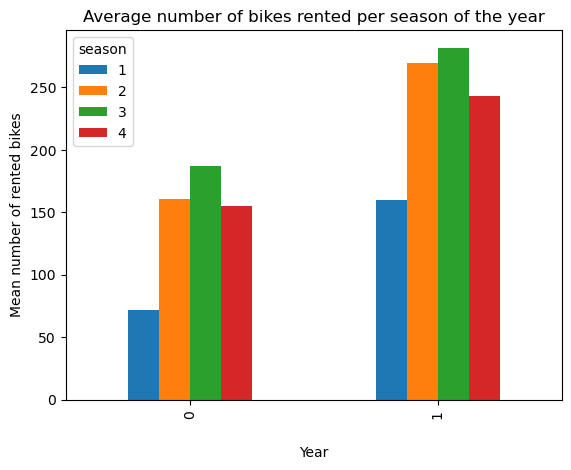

In [209]:
# Season versus count - Mean
plt.close()
df.groupby(['year', 'season'])['count'].mean().unstack().plot(kind="bar")
plt.title("Average number of bikes rented per season of the year")
plt.xlabel("Year", labelpad=20)
plt.ylabel("Mean number of rented bikes")

#### B) Weather condition groups

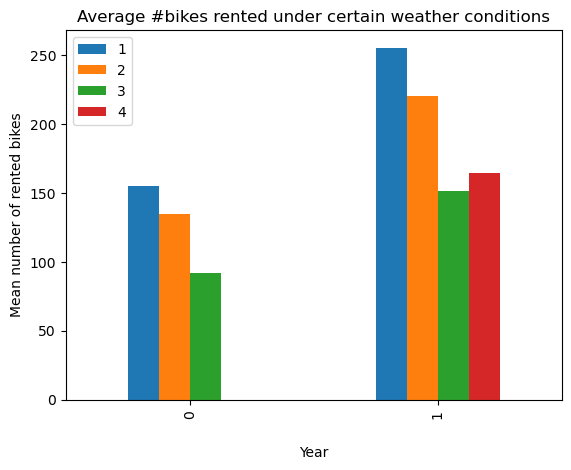

In [210]:
# Weather versus count - Mean
plt.close()
df.groupby(['year', 'weather'])['count'].mean().unstack().plot(kind="bar")
plt.title("Average #bikes rented under certain weather conditions")
plt.xlabel("Year", labelpad=20)
plt.ylabel("Mean number of rented bikes")
plt.legend(loc='upper left')

#### C) Temperature

0.76

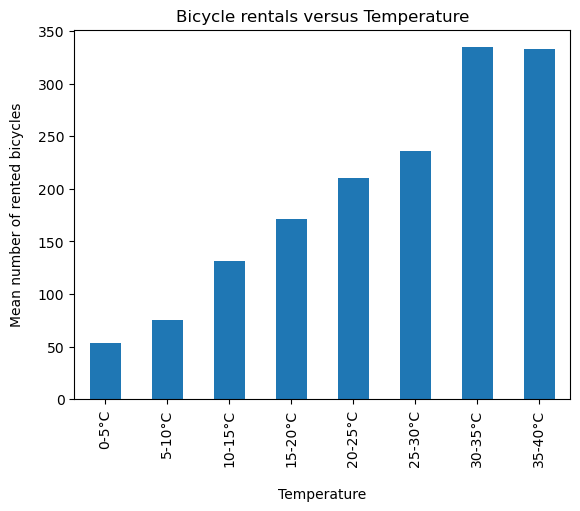

In [211]:
# Weather versus count - Mean
plt.close()
clabels = ['0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '25-30°C', '30-35°C', '35-40°C']
cbins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
df.groupby(pd.cut(df['temp'], cbins, labels=clabels))['count'].mean().plot(kind="bar")
plt.xlabel("Temperature", labelpad=15)
plt.ylabel("Mean number of rented bicycles", labelpad=10)
plt.title("Bicycle rentals versus Temperature")
df['atemp'].min()

#### D) Apparent Temperature

Text(0.5, 1.0, 'Bicycle rentals versus Apparent Temperature')

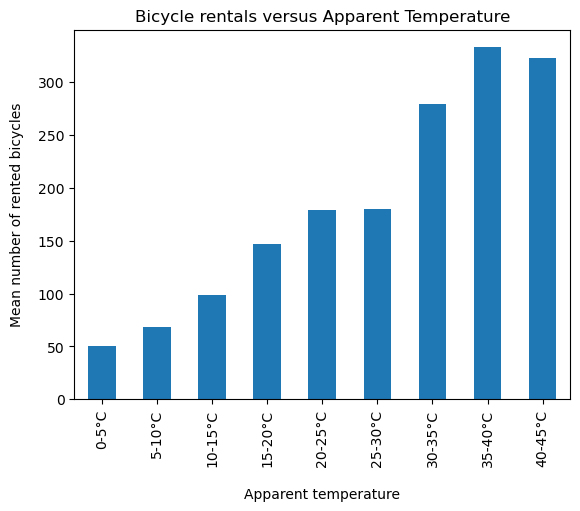

In [212]:
plt.close()
clabels = ['0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '25-30°C', '30-35°C', '35-40°C', '40-45°C']
cbins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
df.groupby(pd.cut(df['atemp'], cbins, labels=clabels))['count'].mean().plot(kind="bar")
plt.xlabel("Apparent temperature", labelpad=15)
plt.ylabel("Mean number of rented bicycles", labelpad=10)
plt.title("Bicycle rentals versus Apparent Temperature")

#### E) Humidity

Text(0.5, 1.0, 'Bicycle rentals versus Humidity')

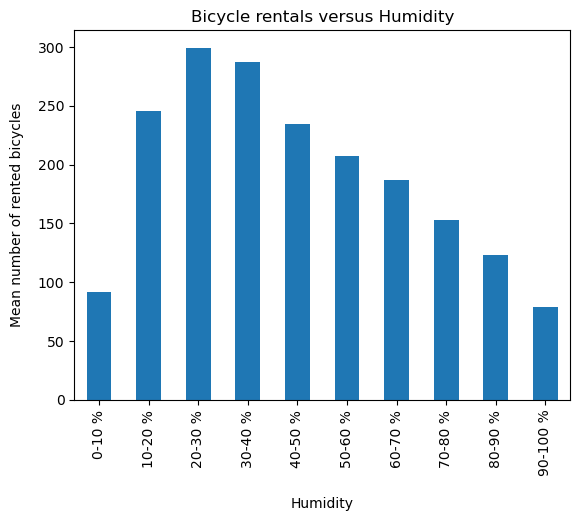

In [213]:
plt.close()
clabels = ['0-10 %', '10-20 %', '20-30 %', '30-40 %', '40-50 %', '50-60 %', '60-70 %', '70-80 %', '80-90 %', '90-100 %']
cbins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df.groupby(pd.cut(df['humidity'], cbins, labels=clabels))['count'].mean().plot(kind="bar")
plt.xlabel("Humidity", labelpad=15)
plt.ylabel("Mean number of rented bicycles", labelpad=10)
plt.title("Bicycle rentals versus Humidity")

Text(0.5, 1.0, 'Bicycle rentals versus Windspeed')

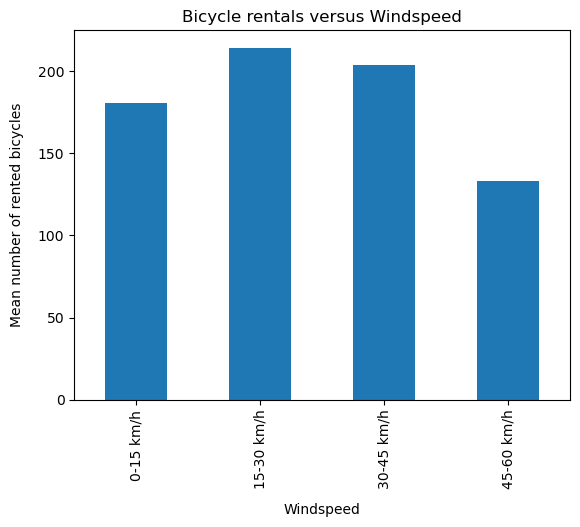

In [214]:
plt.close()
clabels = ['0-15 km/h', '15-30 km/h', '30-45 km/h', '45-60 km/h']
cbins = [0, 15, 30, 45, 60]
df.groupby(pd.cut(df['windspeed'], cbins, labels=clabels))['count'].mean().plot(kind="bar")
plt.xlabel("Windspeed", labelpad=10)
plt.ylabel("Mean number of rented bicycles", labelpad=10)
plt.title("Bicycle rentals versus Windspeed")

## 5. Feature Engineering

### A) Detect highly correlated features

##### Determine pairwise correlations

<AxesSubplot:>

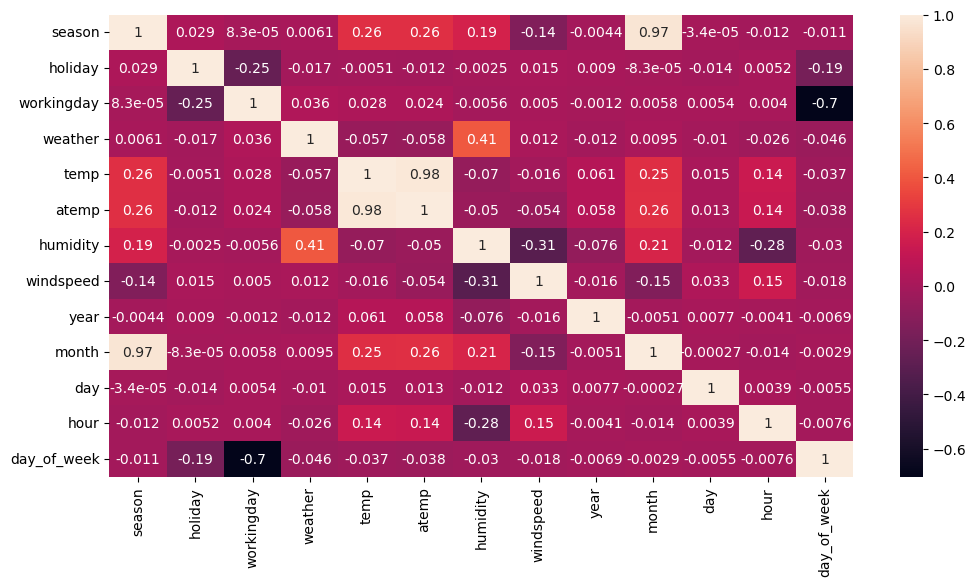

In [215]:
# Determine pairwise correlations
corr = X_train.corr()

# Plot all pairwise correlations as heatmap
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True)

#### Calculate Variance Inflation Factor

In [216]:
X_vif = add_constant(X_train)
X_vif

,const,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,day_of_week
2815,1.0,3,0,1,1,27.88,31.820,83,6.0032,0,7,6,5,2
8695,1.0,3,0,0,1,36.90,40.910,39,19.9995,1,8,4,16,5
8406,1.0,3,0,1,1,32.80,35.605,41,16.9979,1,7,11,15,2
1543,1.0,2,0,0,2,14.76,18.180,93,7.0015,0,4,10,4,6
4952,1.0,4,0,0,1,13.12,15.150,45,16.9979,0,11,19,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.0,1,0,0,1,6.56,8.335,47,11.0014,1,1,14,2,5
5191,1.0,4,0,0,1,11.48,12.880,61,19.0012,0,12,10,9,5
5390,1.0,4,0,0,1,11.48,13.635,48,16.9979,0,12,18,16,6
860,1.0,1,0,0,1,15.58,19.695,17,35.0008,0,2,19,7,5


In [217]:
vifs = []
for i in range(X_vif.shape[1]):
    vif = variance_inflation_factor(X_vif.values,i)
    vifs.append(vif)

pd.Series(vifs,index=X_vif.columns)

const          71.946350
season         18.162872
holiday         1.522602
workingday      2.878442
weather         1.251948
temp           35.518958
atemp          35.594484
humidity        1.550432
windspeed       1.201105
year            1.013112
month          18.252042
day             1.001870
hour            1.121354
day_of_week     2.801703
dtype: float64

In [218]:
# Do not consider atemp and season for now

### B) Check if there are missing values

In [219]:
# Are there NaNs?
X_train[X_train.isna()].count()

season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
year           0
month          0
day            0
hour           0
day_of_week    0
dtype: int64

In [220]:
X_test[X_test.isna()].count()

season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
year           0
month          0
day            0
hour           0
day_of_week    0
dtype: int64

### C) Perform transformation

In [221]:
## from https://lifesaver.codes/answer/cannot-get-feature-names-after-columntransformer-12525

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    # for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
    for transformer_in_columns in column_transformer.transformers_ :#adjusted this line - seems to drop the last transformer, not only remainder
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names_out()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

#### For M1

In [222]:
# Feature transformation
poly2_pipe = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False)
)

cat_pipe = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

# Adding 'season' does not improve model quality
# Implementing a cubed polinomial does not significantly improve the model
feature_transform = ColumnTransformer(transformers=[
    ('do_nothing', 'passthrough', ['year', 'holiday']),
    ('cat_prep', cat_pipe, ['hour', 'month', 'weather', 'day_of_week']),
    ('poly2_prep', poly2_pipe, ['atemp', 'windspeed', 'humidity'])
])

# For training set
X_train_trans = feature_transform.fit_transform(X_train)
feature_names = get_column_names_from_ColumnTransformer(feature_transform)
X_train_m1 = pd.DataFrame(X_train_trans, columns=feature_names[0:X_train_trans.shape[1]])
# For complete dataset
X_trans = feature_transform.fit_transform(X)
X_m1 = pd.DataFrame(X_trans, columns=feature_names[0:X_trans.shape[1]])
# For test set from train/test split
X_test_trans = feature_transform.transform(X_test)
X_test_m1 = pd.DataFrame(X_test_trans, columns=feature_names[0:X_train_trans.shape[1]])
print(X_train_m1.shape)
print(X_train_m1.head())

(8708, 58)
   year  holiday  hour_0  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  \
0   0.0      0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
1   1.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   1.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   0.0      0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
4   0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   hour_7  ...  day_of_week_6        x0        x1    x2      x0^2     x0 x1  \
0     0.0  ...            0.0  0.694932  0.105325  0.83  0.482931  0.073194   
1     0.0  ...            0.0  0.898311  0.350888  0.39  0.806962  0.315206   
2     0.0  ...            0.0  0.779617  0.298225  0.41  0.607803  0.232501   
3     0.0  ...            1.0  0.389753  0.122840  0.93  0.151907  0.047877   
4     0.0  ...            0.0  0.321960  0.298225  0.45  0.103658  0.096017   

      x0 x2      x1^2     x1 x2    x2^2  
0  0.576794  0.

#### For M2

In [223]:
# Create subset of dataframe for time intervals:
# 10:00 - 18:00 : High rental
# 18:00 - 00:00 and 08:00 - 10:00: Medium rental
# 00:00 - 08:00 : Low rentals

conditions_train = [
    ((X_train['hour'] >= 10) & (X_train['hour']<19)),
    (((X_train['hour'] >= 19) & (X_train['hour']<=23))|(X_train['hour']==0)|((X_train['hour']>=9)&(X_train['hour']<=10))),
    ((X_train['hour'] > 0) & (X_train['hour']<9))
]

conditions_test = [
    ((X_test['hour'] >= 10) & (X_test['hour']<19)),
    (((X_test['hour'] >= 19) & (X_test['hour']<=23))|(X_test['hour']==0)|((X_test['hour']>=9)&(X_test['hour']<=10))),
    ((X_test['hour'] > 0) & (X_test['hour']<9))
]

values = ['high_rent_time', 'medium_rent_time', 'low_rent_time']

X_train['timespans_rentals'] = np.select(conditions_train, values)
X_test['timespans_rentals'] = np.select(conditions_test, values)

# Feature transformation
poly2_pipe = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False)
)

cat_pipe = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

feature_transform = ColumnTransformer(transformers=[
    ('do_nothing', 'passthrough', ['year', 'workingday', 'holiday']),
    ('cat_prep', cat_pipe, ['month', 'weather', 'timespans_rentals', 'day_of_week']),
    ('poly2_prep', poly2_pipe, ['atemp', 'windspeed', 'humidity'])
])

# For training set
X_train_trans = feature_transform.fit_transform(X_train)
feature_names = get_column_names_from_ColumnTransformer(feature_transform)
X_train_m2 = pd.DataFrame(X_train_trans, columns=feature_names[0:X_train_trans.shape[1]])

# For test set from train/test split
X_test_trans = feature_transform.transform(X_test)
X_test_m2 = pd.DataFrame(X_test_trans, columns=feature_names[0:X_train_trans.shape[1]])
print(X_train_m2.shape)
print(X_train_m2.head())

# Multiply the column 'time_span' by 'workingday' to account for the fact that only on a workday a strong relationship between
# the time periods and the bicycle rental exists
for n in ['timespans_rentals_high_rent_time', 'timespans_rentals_medium_rent_time', 'timespans_rentals_low_rent_time']:
    X_train_m2.loc[X_train_m2.index, n] = (X_train_m2.loc[X_train_m2.index, n] * X_train_m2.loc[X_train_m2.index, 'workingday'])
    X_test_m2.loc[X_test_m2.index, n] = (X_test_m2.loc[X_test_m2.index, n] * X_test_m2.loc[X_test_m2.index, 'workingday'])
    X_train_m2.drop(['workingday'], axis=1)
    X_test_m2.drop(['workingday'], axis=1)

(8708, 38)
   year  workingday  holiday  month_1  month_2  month_3  month_4  month_5  \
0   0.0         1.0      0.0      0.0      0.0      0.0      0.0      0.0   
1   1.0         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2   1.0         1.0      0.0      0.0      0.0      0.0      0.0      0.0   
3   0.0         0.0      0.0      0.0      0.0      0.0      1.0      0.0   
4   0.0         0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   month_6  month_7  ...  day_of_week_6        x0        x1    x2      x0^2  \
0      0.0      1.0  ...            0.0  0.694932  0.105325  0.83  0.482931   
1      0.0      0.0  ...            0.0  0.898311  0.350888  0.39  0.806962   
2      0.0      1.0  ...            0.0  0.779617  0.298225  0.41  0.607803   
3      0.0      0.0  ...            1.0  0.389753  0.122840  0.93  0.151907   
4      0.0      0.0  ...            0.0  0.321960  0.298225  0.45  0.103658   

      x0 x1     x0 x2      x1^2     x1 x2    x2^2  

#### For M3

In [224]:
# Specific feature design for "hour" time values
def calc_spec_sin(x):
    return math.sin(((0.33*x-3.17) * 0.5) + 0.5)

X_train['hour_trans'] = X_train.apply(lambda x: calc_spec_sin(x.hour), axis=1)
X_test['hour_trans'] = X_test.apply(lambda x: calc_spec_sin(x.hour), axis=1)

feature_transform = ColumnTransformer(transformers=[
    ('do_nothing', 'passthrough', ['year', 'hour_trans', 'workingday', 'holiday']),
    ('cat_prep', cat_pipe, ['month']),
    ('poly2_prep', poly2_pipe, ['atemp', 'humidity', 'windspeed'])
])

# For training set
X_train_trans = feature_transform.fit_transform(X_train)
feature_names = get_column_names_from_ColumnTransformer(feature_transform)
X_train_m3 = pd.DataFrame(X_train_trans, columns=feature_names[0:X_train_trans.shape[1]])

# For test set from train/test split
X_test_trans = feature_transform.transform(X_test)
X_test_m3 = pd.DataFrame(X_test_trans, columns=feature_names[0:X_train_trans.shape[1]])
print(X_train_m3.shape)
print(X_train_m3.head())

(8708, 25)
   year  hour_trans  workingday  holiday  month_1  month_2  month_3  month_4  \
0   0.0   -0.257081         1.0      0.0      0.0      0.0      0.0      0.0   
1   1.0    0.999875         0.0      0.0      0.0      0.0      0.0      0.0   
2   1.0    0.983701         1.0      0.0      0.0      0.0      0.0      0.0   
3   0.0   -0.412321         0.0      0.0      0.0      0.0      0.0      1.0   
4   0.0    0.535416         0.0      0.0      0.0      0.0      0.0      0.0   

   month_5  month_6  ...  month_12        x0    x1        x2      x0^2  \
0      0.0      0.0  ...       0.0  0.694932  0.83  0.105325  0.482931   
1      0.0      0.0  ...       0.0  0.898311  0.39  0.350888  0.806962   
2      0.0      0.0  ...       0.0  0.779617  0.41  0.298225  0.607803   
3      0.0      0.0  ...       0.0  0.389753  0.93  0.122840  0.151907   
4      0.0      0.0  ...       0.0  0.321960  0.45  0.298225  0.103658   

      x0 x1     x0 x2    x1^2     x1 x2      x2^2  
0  0.576794

## 6. Generate model

### Random forest regression model

#### Model M1

In [225]:
random_forest_m1 = RandomForestRegressor(max_depth=9, random_state=0)
random_forest_m1.fit(X_train_m1, y_train)
feature_importance_dict = {'importance': random_forest_m1.feature_importances_, 'feature': X_train_m1.columns}
pd.DataFrame(data=feature_importance_dict).sort_values('importance', ascending=False)

,importance,feature
19,0.132359,hour_17
49,0.117519,x0
20,0.114270,hour_18
52,0.110848,x0^2
0,0.104356,year
10,0.078226,hour_8
48,0.049529,day_of_week_6
47,0.045973,day_of_week_5
21,0.039678,hour_19
57,0.033620,x2^2


In [226]:
print("Accuracy based on training data:", round(random_forest_m1.score(X_train_m1, y_train), 3))
print("Accuracy based on training data:", round(random_forest_m1.score(X_test_m1, y_test), 3))
# For the same features the random forest algorithm gets a model with a comparable accuracy
# Although it looks a bit overfitted.

# For further fine tuning could be reasonable to drop unimportant features and try different hyperparameters
# But generally too many features used by this model.

Accuracy based on training data: 0.766
Accuracy based on training data: 0.705


In [237]:
# Kfold crossvalidation
cv = KFold(n_splits=5, shuffle=True, random_state=3)

cv_result_m1 = cross_val_score(
    estimator=random_forest_m1, # the model to evaluate
    X=X_m1,
    y=y,
    scoring='r2', # evaluation metrics
    cv=cv, # cross validation splitting
    verbose=5
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.714) total time=   7.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] END ................................ score: (test=0.728) total time=   5.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s


[CV] END ................................ score: (test=0.716) total time=   5.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.8s remaining:    0.0s


[CV] END ................................ score: (test=0.731) total time=   7.3s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.3s remaining:    0.0s


[CV] END ................................ score: (test=0.711) total time=   6.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.6s finished


In [238]:
print(f'Validation r2 scores:\n{np.round(cv_result_m1,2)}')
print(f'\nmean: {cv_result_m1.mean():.3}')
print(f'std: {cv_result_m1.std():.2}')

Validation r2 scores:
[0.71 0.73 0.72 0.73 0.71]

mean: 0.72
std: 0.008


In [239]:
# Calculate for log(y)
random_forest_log = RandomForestRegressor(max_depth=8, random_state=0)
y_train_f1l_log = np.log1p(y_train)
y_test_f1l_log = np.log1p(y_test)
random_forest_log.fit(X_train_m1, y_train_f1l_log)
feature_importance_dict = {'importance': random_forest_log.feature_importances_, 'feature': X_train_m1.columns}
pd.DataFrame(data=feature_importance_dict).sort_values('importance', ascending=False)

,importance,feature
6,0.206527,hour_4
5,0.176056,hour_3
4,0.136303,hour_2
7,0.131174,hour_5
3,0.107478,hour_1
2,0.051523,hour_0
49,0.039955,x0
52,0.039645,x0^2
48,0.026927,day_of_week_6
47,0.026169,day_of_week_5


### Linear regression model

#### M1: Model based on same features as random forest model

Accurancy for the training set based on log(y): 0.838
Mean squared error for test set based on log(y): 0.838
Accurancy for the training set: 0.738
Mean squared error for test set: 8709.319
Mean absolute error for test set: 60.592
R2 for the test set: 0.736


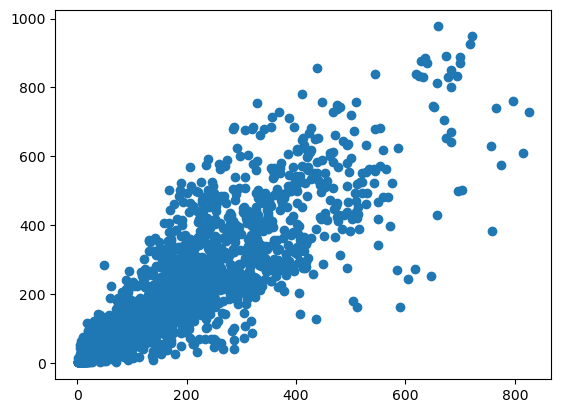

In [227]:
m1= LinearRegression()
# Change y to log-scale to prevent negative values
y_train_m1_log = np.log1p(y_train)
y_test_m1_log = np.log1p(y_test)
m1.fit(X_train_m1, y_train_m1_log)
w0 = m1.intercept_
w1 = m1.coef_
#print("Weights are ", w1, "for the coefficient and", w0, "for the intercept.")

y_pred_m1_test_log = m1.predict(X_test_m1)
y_pred_m1_train_log = m1.predict(X_train_m1)
y_pred_m1_test = np.exp(y_pred_m1_test_log)-1
y_pred_m1_train = np.exp(y_pred_m1_train_log)-1

# Note: Calculating the accuracy (R2) based on the log scale values with lead to too favourable R2 values
print("Accurancy for the training set based on log(y):", round(r2_score(y_train_m1_log, y_pred_m1_train_log),3))
print("Mean squared error for test set based on log(y):", round(r2_score(y_test_m1_log, y_pred_m1_test_log),3))

print("Accurancy for the training set:", round(r2_score(y_train, y_pred_m1_train),3))
print("Mean squared error for test set:", round(mean_squared_error(y_test, y_pred_m1_test),3))
print("Mean absolute error for test set:", round(mean_absolute_error(y_test, y_pred_m1_test),3))
print("R2 for the test set:", round(r2_score(y_test, y_pred_m1_test), 3))

# Back-transform
plt.scatter(y_pred_m1_test, y_test)

Apply REF

In [228]:
# 58 columns is still a lot - Apply RFE
rfe = RFE(estimator= m1, verbose=0, n_features_to_select=50)
rfe.fit(X_train_m1, y_train_m1_log)
feature_to_include = rfe.feature_names_in_[rfe.support_] # Features to include
print(f'Including only the features {feature_to_include}\nR^2 score for training set is {round(rfe.score(X_train_m1, y_train_m1_log),2)}')
print(f'Including only the features {feature_to_include}\nR^2 score for test set is {round(rfe.score(X_test_m1, y_test_m1_log),2)}')
# Even a decrease to 50 features leads to a decrease of the R2 score.

Including only the features ['hour_0' 'hour_1' 'hour_2' 'hour_3' 'hour_4' 'hour_5' 'hour_6' 'hour_7'
 'hour_8' 'hour_9' 'hour_10' 'hour_11' 'hour_12' 'hour_13' 'hour_14'
 'hour_15' 'hour_16' 'hour_17' 'hour_18' 'hour_19' 'hour_20' 'hour_21'
 'hour_22' 'hour_23' 'month_1' 'month_2' 'month_3' 'month_4' 'month_5'
 'month_6' 'month_7' 'month_8' 'month_9' 'month_10' 'month_11' 'month_12'
 'weather_1' 'weather_2' 'weather_3' 'weather_4' 'day_of_week_1'
 'day_of_week_4' 'day_of_week_5' 'x0' 'x1' 'x2' 'x0^2' 'x1^2' 'x1 x2'
 'x2^2']
R^2 score for training set is 0.81
Including only the features ['hour_0' 'hour_1' 'hour_2' 'hour_3' 'hour_4' 'hour_5' 'hour_6' 'hour_7'
 'hour_8' 'hour_9' 'hour_10' 'hour_11' 'hour_12' 'hour_13' 'hour_14'
 'hour_15' 'hour_16' 'hour_17' 'hour_18' 'hour_19' 'hour_20' 'hour_21'
 'hour_22' 'hour_23' 'month_1' 'month_2' 'month_3' 'month_4' 'month_5'
 'month_6' 'month_7' 'month_8' 'month_9' 'month_10' 'month_11' 'month_12'
 'weather_1' 'weather_2' 'weather_3' 'weather_4' 

Apply Lasso

Accurancy for the training set: 0.673
Mean squared error for test set: 10825.707
Mean absolute error for test set: 75.654
R2 for the test set: 0.672


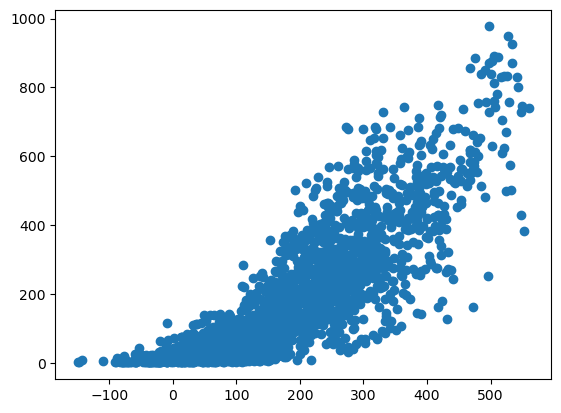

In [229]:
# Apply Lasso (for testing) - Although no overfitting is visible in the calculated R2 values for train and test set
# Apply it to the y not the log(y) values, as the latter does not seem to work

m1l = Lasso(alpha = 1)
m1l.fit(X_train_m1, y_train)
# save prediction as ypred_lasso
w0 = m1l.intercept_
w1 = m1l.coef_
# print("Weights are ", w1, "for the coefficient and", w0, "for the intercept.")

y_pred_m1l_test = m1l.predict(X_test_m1)
y_pred_m1l_train = m1l.predict(X_train_m1)

print("Accurancy for the training set:", round(r2_score(y_train, y_pred_m1l_train),3))
print("Mean squared error for test set:", round(mean_squared_error(y_test, y_pred_m1l_test),3))
print("Mean absolute error for test set:", round(mean_absolute_error(y_test, y_pred_m1l_test),3))
print("R2 for the test set:", round(r2_score(y_test, y_pred_m1l_test), 3))

# Plot predicted versus actual data
plt.scatter(y_pred_m1l_test, y_test)

# Observation: The intercept and slope values are significantly smaller than
#              those found for the Linear Regression model -> Approach works,
#              but does not need to be applied here, since no overfitting was
#              observed and applying Lasso leads to lower accurac (R2) values.

#### M2: Model based on encoded time ranges

Accurancy for the training set based on log(y): 0.406
Mean squared error for test set based on log(y): 0.426
Accurancy for the training set: 0.219
Mean squared error for test set: 24773.161
Mean absolute error for test set: 104.641
R2 for the test set: 0.249


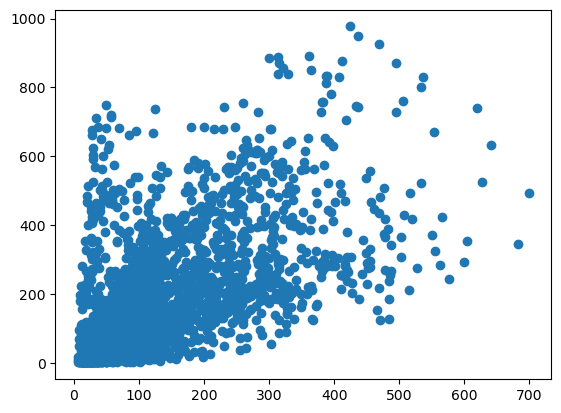

In [230]:
m2 = LinearRegression()
# Change y to log-scale to prevent negative values
y_train_m2_log = np.log1p(y_train)
y_test_m2_log = np.log1p(y_test)
m2.fit(X_train_m2, y_train_m2_log)
w0 = m2.intercept_
w1 = m2.coef_
#print("Weights are ", w1, "for the coefficient and", w0, "for the intercept.")

y_pred_m2_test_log = m2.predict(X_test_m2)
y_pred_m2_train_log = m2.predict(X_train_m2)
y_pred_m2_test = np.exp(y_pred_m2_test_log)-1
y_pred_m2_train = np.exp(y_pred_m2_train_log)-1

# Note: Calculating the accuracy (R2) based on the log scale values with lead to too favourable R2 values
print("Accurancy for the training set based on log(y):", round(r2_score(y_train_m2_log, y_pred_m2_train_log),3))
print("Mean squared error for test set based on log(y):", round(r2_score(y_test_m2_log, y_pred_m2_test_log),3))

print("Accurancy for the training set:", round(r2_score(y_train, y_pred_m2_train),3))
print("Mean squared error for test set:", round(mean_squared_error(y_test, y_pred_m2_test),3))
print("Mean absolute error for test set:", round(mean_absolute_error(y_test, y_pred_m2_test),3))
print("R2 for the test set:", round(r2_score(y_test, y_pred_m2_test), 3))

# Back-transform
plt.scatter(y_pred_m2_test, y_test)

In [231]:
#### Approach not successful. Best Linear Regression model: M1

#### M3: Model based on designed time values

Accurancy for the training set: 0.519
Mean squared error for test set: 15528.238
Mean absolute error for test set: 78.827
R2 for the test set: 0.53


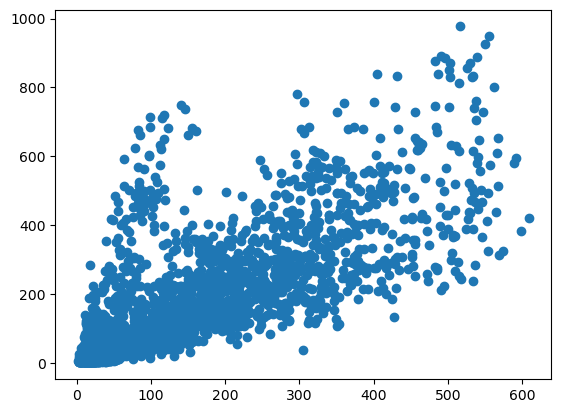

In [232]:
m3 = LinearRegression()
# Change y to log-scale to prevent negative values
y_train_m3_log = np.log1p(y_train)
y_test_m3_log = np.log1p(y_test)
m3.fit(X_train_m3, y_train_m3_log)
w0 = m3.intercept_
w1 = m3.coef_
#print("Weights are ", w1, "for the coefficient and", w0, "for the intercept.")

y_pred_m3_test_log = m3.predict(X_test_m3)
y_pred_m3_train_log = m3.predict(X_train_m3)
y_pred_m3_test = np.exp(y_pred_m3_test_log)-1
y_pred_m3_train = np.exp(y_pred_m3_train_log)-1

print("Accurancy for the training set:", round(r2_score(y_train, y_pred_m3_train),3))
print("Mean squared error for test set:", round(mean_squared_error(y_test, y_pred_m3_test),3))
print("Mean absolute error for test set:", round(mean_absolute_error(y_test, y_pred_m3_test),3))
print("R2 for the test set:", round(r2_score(y_test, y_pred_m3_test), 3))

# Back-transform
plt.scatter(y_pred_m3_test, y_test)

In [235]:
# Model is better than M2, but still not good enough. The most successful model was M1, comprising 58 features.
# Decreasing the number of features resulted in a large drop in model accuracy

### RMSLE calculation

Calculate Root Mean Squared Log Error for the Random Forest Model

In [240]:
from sklearn.metrics import mean_squared_log_error
y_pred_train_log_rf = random_forest_log.predict(X_train_m1)
y_pred_test_log_rf = random_forest_log.predict(X_test_m1)
y_pred_train_rf = np.exp(y_pred_train_log_rf)-1
y_pred_test_rf = np.exp(y_pred_test_log_rf)-1
kaggle_score_training_set_rf = np.sqrt(mean_squared_log_error(y_true=y_train, y_pred=y_pred_train_rf))
kaggle_score_validation_set_rf = np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_pred_test_rf))
print("KAGGLE score for training set:", round(kaggle_score_training_set_rf,3))
print("KAGGLE score for validation set:", round(kaggle_score_validation_set_rf, 3))

KAGGLE score for training set: 0.653
KAGGLE score for validation set: 0.688


Calculate Root Mean Squared Log Error for the best Linear Regression model

In [241]:
y_pred_train_log = m1.predict(X_train_m1)
y_pred_test_log = m1.predict(X_test_m1)
y_pred_train = np.exp(y_pred_train_log)-1
y_pred_test = np.exp(y_pred_test_log)-1
kaggle_score_training_set = np.sqrt(mean_squared_log_error(y_true=y_train, y_pred=y_pred_train))
kaggle_score_validation_set = np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_pred_test))
print("KAGGLE score for training set:", round(kaggle_score_training_set,3))
print("KAGGLE score for validation set:", round(kaggle_score_validation_set, 3))

KAGGLE score for training set: 0.57
KAGGLE score for validation set: 0.577
